# Bank Review Analysis

***Central banks collecting information about customer satisfaction with the services provided by different bank. Also collects the information about the complaints.***


***The objective of the case study is to analyze customer reviews and predict customer satisfaction with the reviews***

- Data processing
- Key positive words/negative words (most frequent words)
- Classification of reviews into positive, negative and neutral
- Identify key themes of problems (using clustering, topic models)
- Predicting star ratings using reviews.
- Perform intent analysis

***The data is a detailed dump of customer reviews/complaints (~500) of different services at different banks***

- Date (Day the review was posted)
- Stars (1–5 rating for the business)
- text (Review text)
- bank name

## Data Pre-Processing

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_excel('BankReviews.xlsx')

In [3]:
df.head()

,Date,Stars,Reviews,BankName
0,2017-04-10,5,"Great job, Wyndham Capital! Each person was pr...",Wyndham Capital Mortgage
1,2017-02-10,5,Matthew Richardson is professional and helpful...,Wyndham Capital Mortgage
2,2017-08-21,5,We had a past experience with Wyndham Mortgage...,Wyndham Capital Mortgage
3,2017-12-17,5,We have been dealing with Brad Thomka from the...,Wyndham Capital Mortgage
4,2016-05-27,5,I can't express how grateful I am for the supp...,Wyndham Capital Mortgage


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      505 non-null    datetime64[ns]
 1   Stars     505 non-null    int64         
 2   Reviews   505 non-null    object        
 3   BankName  505 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 15.9+ KB


In [5]:
df.isnull().sum()

Date        0
Stars       0
Reviews     0
BankName    0
dtype: int64

In [6]:
df['Reviews'][0]

'Great job, Wyndham Capital! Each person was professional and helped us move through our refinance process smoothly. Thank you!'

## Dropping the Date Column as it doesn't have any affect on the data based on our objective

In [7]:
df.drop('Date', axis=1, inplace=True)

### Checking if there's any empty string in a Review column

In [8]:
blanks = []
for i, st, rv, bn in df.itertuples():
    if type(rv) == str:
        if rv.isspace():
            blanks.append(i)

In [9]:
blanks

[]

### No empty strings are found, so that's good.

### Checking each individual word's sentiment after tokenizing them.

In [10]:
import spacy
nlp = spacy.load('en_core_web_lg')

In [11]:
for token in nlp(df['Reviews'][0]):
    if (token.is_punct) | (nlp.vocab[str(token)].is_stop):
        continue
    else:
        print(token.lemma_)

great
job
Wyndham
Capital
person
professional
help
refinance
process
smoothly
thank


In [12]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [13]:
sia = SentimentIntensityAnalyzer()

#### This function takes the document, and then tokenize it after removing any punctuations and stop words. And then lemmatize it before checking it's sentiment. It returns a dictionary classifying each word from a review as positive, negative or neutral.

In [14]:
def word_sentiment(doc):
    word_sent = {}
    for token in nlp(doc):
        if (token.is_punct) | (nlp.vocab[str(token)].is_stop):
            continue
        else:
            if sia.polarity_scores(token.lemma_)['pos'] == 1.0:
                word_sent[token.lemma_] = 'Positive'
            elif sia.polarity_scores(token.lemma_)['neg'] == 1.0:
                word_sent[token.lemma_] = 'Negative'
            elif sia.polarity_scores(token.lemma_)['neu'] == 1.0:
                word_sent[token.lemma_] = 'Neutral'
    return word_sent

### Adding a new column 'Word_Sentiment' by applying the 'word_sentiment()' function to the 'Reviews' column.

In [15]:
df['Word_Sentiment'] = df['Reviews'].apply(word_sentiment)

In [16]:
df.head()

,Stars,Reviews,BankName,Word_Sentiment
0,5,"Great job, Wyndham Capital! Each person was pr...",Wyndham Capital Mortgage,"{'great': 'Positive', 'job': 'Neutral', 'Wyndh..."
1,5,Matthew Richardson is professional and helpful...,Wyndham Capital Mortgage,"{'Matthew': 'Neutral', 'Richardson': 'Neutral'..."
2,5,We had a past experience with Wyndham Mortgage...,Wyndham Capital Mortgage,"{'past': 'Neutral', 'experience': 'Neutral', '..."
3,5,We have been dealing with Brad Thomka from the...,Wyndham Capital Mortgage,"{'deal': 'Neutral', 'Brad': 'Neutral', 'Thomka..."
4,5,I can't express how grateful I am for the supp...,Wyndham Capital Mortgage,"{'express': 'Neutral', 'grateful': 'Positive',..."


### Let's check

In [17]:
print(df['Reviews'][0])
print('\n')
print(df['Word_Sentiment'][0])

Great job, Wyndham Capital! Each person was professional and helped us move through our refinance process smoothly. Thank you!


{'great': 'Positive', 'job': 'Neutral', 'Wyndham': 'Neutral', 'Capital': 'Neutral', 'person': 'Neutral', 'professional': 'Neutral', 'help': 'Positive', 'refinance': 'Neutral', 'process': 'Neutral', 'smoothly': 'Neutral', 'thank': 'Positive'}


### 'positives' and 'negatives' are two dictionaries contains all the positive and negative words respectively, and their frequencies. We've done so in order to find the top most frequent positive and negative words in our corpus.

In [18]:
positives = {}
negatives = {}
for i in range(len(df['Word_Sentiment'])):
    for j in df['Word_Sentiment'][i]:
        if sia.polarity_scores(j)['pos'] == 1.0:
            if j not in positives.keys():
                positives[j] = 1
            else:
                positives[j] += 1
        elif sia.polarity_scores(j)['neg'] == 1.0:
            if j not in negatives.keys():
                negatives[j] = 1
            else:
                negatives[j] += 1
        elif sia.polarity_scores(j)['neu'] == 1.0:
            continue

In [19]:
# pos_lis = []
# for i in positives.keys():
#     pos_lis.append((i, positives[i]))

In [20]:
# pos_lis = sorted(pos_lis, key=lambda x:x[1], reverse=True)

In [21]:
# neg_lis = []
# for i in negatives.keys():
#     neg_lis.append((i, negatives[i]))

In [22]:
# neg_lis = sorted(neg_lis, key=lambda x:x[1], reverse=True)

In [23]:
# len(neg_lis)

# Top 50 most frequent positive words.

In [24]:
from PIL import Image

In [25]:
from wordcloud import WordCloud

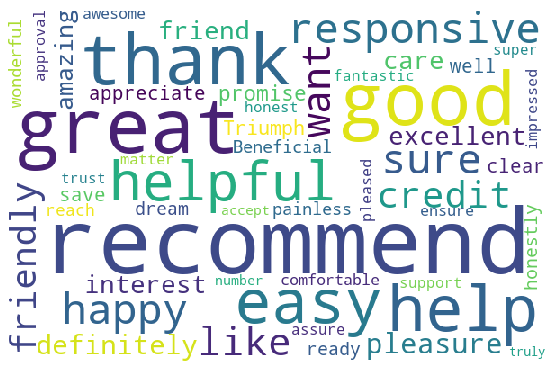

In [26]:
wc = WordCloud(background_color="white", width=600, height=400, max_words=50, relative_scaling=0.5, normalize_plurals=False).generate_from_frequencies(positives)
plt.figure(figsize=(15,5))
plt.axis("off")
plt.tight_layout(pad=0)
plt.imshow(wc)

# Top 50 most frequent negative words.

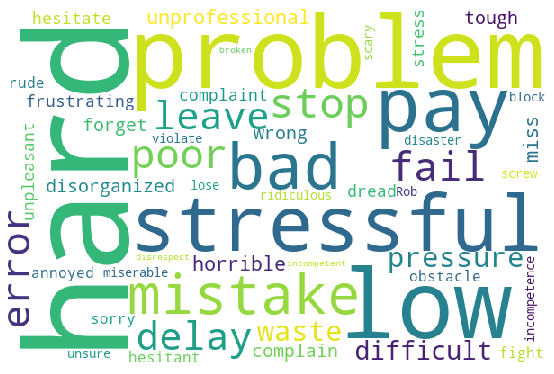

In [27]:
wc = WordCloud(background_color="white", width=600, height=400, max_words=50, relative_scaling=0.5, normalize_plurals=False).generate_from_frequencies(negatives)
plt.figure(figsize=(15,5))
plt.axis("off")
plt.tight_layout(pad=0)
plt.imshow(wc)

## Now it's time to label our reviews as Positive, Negative, or Netural.

In [28]:
sia.polarity_scores(df['Reviews'][0])

{'neg': 0.0, 'neu': 0.703, 'pos': 0.297, 'compound': 0.8011}

## Adding a new column 'Compound' and based on it's value we'll label our reviews

In [29]:
df['Compound'] = df['Reviews'].apply(lambda x: sia.polarity_scores(x)['compound'])

In [30]:
df.head()

,Stars,Reviews,BankName,Word_Sentiment,Compound
0,5,"Great job, Wyndham Capital! Each person was pr...",Wyndham Capital Mortgage,"{'great': 'Positive', 'job': 'Neutral', 'Wyndh...",0.8011
1,5,Matthew Richardson is professional and helpful...,Wyndham Capital Mortgage,"{'Matthew': 'Neutral', 'Richardson': 'Neutral'...",0.8516
2,5,We had a past experience with Wyndham Mortgage...,Wyndham Capital Mortgage,"{'past': 'Neutral', 'experience': 'Neutral', '...",0.9595
3,5,We have been dealing with Brad Thomka from the...,Wyndham Capital Mortgage,"{'deal': 'Neutral', 'Brad': 'Neutral', 'Thomka...",0.9818
4,5,I can't express how grateful I am for the supp...,Wyndham Capital Mortgage,"{'express': 'Neutral', 'grateful': 'Positive',...",0.5569


### Function 'sent_detect()' will take the compound value as it's argument and returns the one label out of three. 'Positive' or 'Negative' or 'Neutral'.

In [31]:
def sent_detect(comp):
    if comp > 0:
        return 'Positive'
    elif comp == 0:
        return 'Neutral'
    else:
        return 'Negative'

### Creating a new column 'Review_Sentiment' by applying the 'sent_detect()' function to the column 'Compound'.

In [32]:
df['Review_Sentiment'] = df['Compound'].apply(sent_detect)

#### Counting the newly created labels

In [33]:
df['Review_Sentiment'].value_counts()

Positive    430
Negative     65
Neutral      10
Name: Review_Sentiment, dtype: int64

In [34]:
df['Stars'].value_counts()

5    410
1     95
Name: Stars, dtype: int64

# Topic Modeling

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [36]:
tfidf = TfidfVectorizer(max_df=0.9, min_df=2, stop_words='english')

In [37]:
dtm = tfidf.fit_transform(df['Reviews'])

In [38]:
dtm

<505x1598 sparse matrix of type '<class 'numpy.float64'>'
	with 13750 stored elements in Compressed Sparse Row format>

## Non-Negative Matrix Factorization method

In [39]:
from sklearn.decomposition import NMF

In [40]:
nmf = NMF(n_components=7)

In [41]:
nmf.fit(dtm)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=7, random_state=None, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [42]:
nmf.n_components_

7

In [43]:
nmf.components_

array([[0.        , 0.03172406, 0.        , ..., 0.19979787, 0.00824873,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.00021294, 0.00566405, 0.        , ..., 0.03240977, 0.        ,
        0.00230635],
       [0.        , 0.        , 0.04110511, ..., 0.        , 0.00088998,
        0.        ],
       [0.06051295, 0.0160264 , 0.        , ..., 0.03512562, 0.01101833,
        0.01551874]])

## Displaying Topics

In [44]:
len(tfidf.get_feature_names())

1598

In [45]:
import random

In [46]:
for i in range(10):
    random_word_id = random.randint(0,1598)
    print(tfidf.get_feature_names()[random_word_id])

smooth
circumstances
32
ownership
daughter
prior
forwarding
vacation
quickly
initiate


In [47]:
for i in range(10):
    random_word_id = random.randint(0,1598)
    print(tfidf.get_feature_names()[random_word_id])

didnt
adan
educate
klossner
understands
consolidate
tim
humanly
occasion
regret


In [48]:
len(nmf.components_[0])

1598

In [49]:
single_topic = nmf.components_[0]

In [50]:
single_topic.argsort()

array([   0,  808,  809, ...,  680, 1168,  686], dtype=int64)

In [51]:
single_topic.argsort()[-10:]

array([  48,  162, 1426,  385,  853, 1134, 1094,  680, 1168,  686],
      dtype=int64)

In [52]:
for i in single_topic.argsort()[-10:]:
    print(tfidf.get_feature_names()[i])

adam
best
team
dean
loan
questions
process
highly
recommend
home


## Tagging each component using enumerate and displaying top 15 most significant words per topic.

In [53]:
for index, topic in enumerate(nmf.components_):
    print(f'Top 15 words for Topic {index+1}:')
    print('\n')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

Top 15 words for Topic 1:


['worked', 'step', 'amazing', 'help', 'helped', 'adam', 'best', 'team', 'dean', 'loan', 'questions', 'process', 'highly', 'recommend', 'home']


Top 15 words for Topic 2:


['peter', 'website', 'quickly', 'informed', 'team', 'tedious', 'quick', 'answered', 'questions', 'got', 'process', 'easy', 'responsive', 'work', 'great']


Top 15 words for Topic 3:


['helpful', 'knowledgeable', 'passing', 'process', 'patient', 'extremely', 'loan', 'husband', 'simple', 'accurate', 'quick', 'asset', 'mortgage', 'barrett', 'jon']


Top 15 words for Topic 4:


['oriented', 'mortgage', 'jeremy', 'excellent', 'dallas', 'heartily', 'fast', 'outstanding', 've', 'people', 'timely', 'great', 'helpful', 'customer', 'service']


Top 15 words for Topic 5:


['experience', 'best', 'bryant', 'different', 'complicated', 'home', 'worked', 'loans', 'loan', 'team', 'entire', 'time', 'va', 'kory', 'nasb']


Top 15 words for Topic 6:


['looking', 'ask', 'commented', 'escrows', 'lender', 'r

## Topic Results

In [54]:
topic_results = nmf.transform(dtm)

In [55]:
topic_results

array([[0.08405654, 0.10038504, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01922024, 0.        , 0.01302855, ..., 0.        , 0.01482277,
        0.        ],
       [0.06690103, 0.        , 0.0272642 , ..., 0.03774524, 0.01589188,
        0.00189737],
       ...,
       [0.        , 0.01528199, 0.        , ..., 0.01796684, 0.01488472,
        0.27116566],
       [0.00483114, 0.        , 0.0033671 , ..., 0.00858014, 0.        ,
        0.25789595],
       [0.        , 0.        , 0.        , ..., 0.03934005, 0.        ,
        0.2157998 ]])

In [56]:
len(topic_results)

505

In [57]:
len(df['Reviews'])

505

### Let's tag all the reviews by their topic number.

In [58]:
df['Topic'] = topic_results.argmax(axis=1) + 1

In [59]:
df.head()

,Stars,Reviews,BankName,Word_Sentiment,Compound,Review_Sentiment,Topic
0,5,"Great job, Wyndham Capital! Each person was pr...",Wyndham Capital Mortgage,"{'great': 'Positive', 'job': 'Neutral', 'Wyndh...",0.8011,Positive,2
1,5,Matthew Richardson is professional and helpful...,Wyndham Capital Mortgage,"{'Matthew': 'Neutral', 'Richardson': 'Neutral'...",0.8516,Positive,4
2,5,We had a past experience with Wyndham Mortgage...,Wyndham Capital Mortgage,"{'past': 'Neutral', 'experience': 'Neutral', '...",0.9595,Positive,1
3,5,We have been dealing with Brad Thomka from the...,Wyndham Capital Mortgage,"{'deal': 'Neutral', 'Brad': 'Neutral', 'Thomka...",0.9818,Positive,1
4,5,I can't express how grateful I am for the supp...,Wyndham Capital Mortgage,"{'express': 'Neutral', 'grateful': 'Positive',...",0.5569,Positive,1


## Creating the context for our reviews by mapping each topic with a string name that is carefully considered after analysing the top 15 words per topic.

In [60]:
topic_mapping = {1: 'Good Service', 2: 'Quick Response', 3: 'Simple Process', 4: 'Helpful Customer Care', 5: 'Experienced Staff', 6: 'Real Estate Experience', 7: 'Delayed/No Response'}

In [61]:
df['Topic'] = df['Topic'].map(topic_mapping)

In [62]:
df.head()

,Stars,Reviews,BankName,Word_Sentiment,Compound,Review_Sentiment,Topic
0,5,"Great job, Wyndham Capital! Each person was pr...",Wyndham Capital Mortgage,"{'great': 'Positive', 'job': 'Neutral', 'Wyndh...",0.8011,Positive,Quick Response
1,5,Matthew Richardson is professional and helpful...,Wyndham Capital Mortgage,"{'Matthew': 'Neutral', 'Richardson': 'Neutral'...",0.8516,Positive,Helpful Customer Care
2,5,We had a past experience with Wyndham Mortgage...,Wyndham Capital Mortgage,"{'past': 'Neutral', 'experience': 'Neutral', '...",0.9595,Positive,Good Service
3,5,We have been dealing with Brad Thomka from the...,Wyndham Capital Mortgage,"{'deal': 'Neutral', 'Brad': 'Neutral', 'Thomka...",0.9818,Positive,Good Service
4,5,I can't express how grateful I am for the supp...,Wyndham Capital Mortgage,"{'express': 'Neutral', 'grateful': 'Positive',...",0.5569,Positive,Good Service


In [63]:
df['Topic'].value_counts()

Good Service              146
Delayed/No Response       122
Quick Response             82
Experienced Staff          52
Helpful Customer Care      51
Real Estate Experience     32
Simple Process             20
Name: Topic, dtype: int64

Text(0, 0.5, 'Topic Frequency')

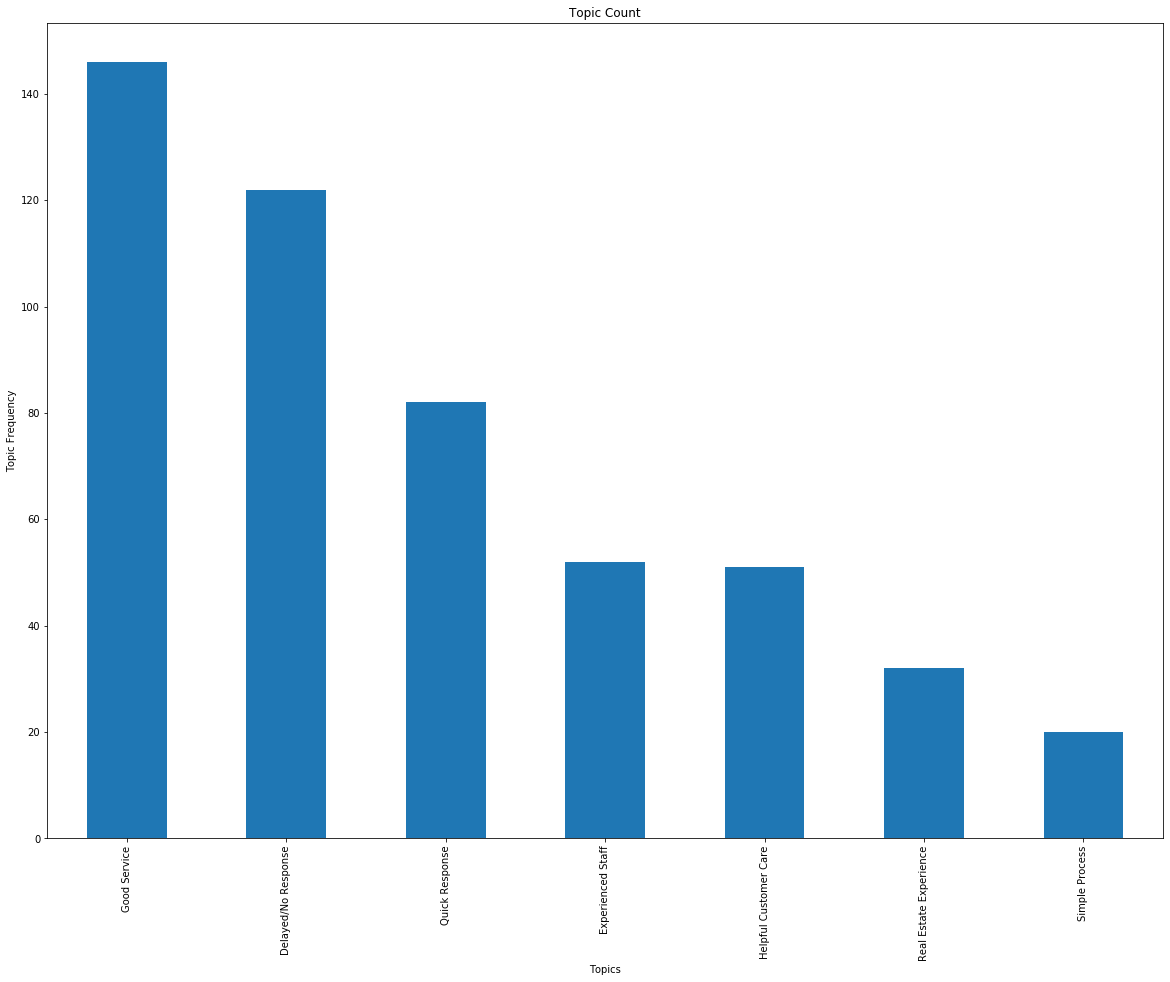

In [66]:
plt.figure(figsize=(20, 15))
df['Topic'].value_counts().plot(kind='bar')
plt.title('Topic Count')
plt.xlabel('Topics')
plt.ylabel('Topic Frequency')

## Selecting the Independent and Dependent Variable

In [67]:
X = df['Reviews']
y = df['Stars']

## Splitting the data into training and testing set

In [68]:
from sklearn.model_selection import train_test_split

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

## Building the model using LinearSVC

In [70]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

In [71]:
from sklearn.pipeline import Pipeline

In [72]:
pipe = Pipeline([('tfidf', TfidfVectorizer()), ('svc', LinearSVC())])

In [73]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('svc',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
               

### Predicting the values

In [74]:
y_pred = pipe.predict(X_test)

# Results

### Comparison between Actual and Predicted Target values.

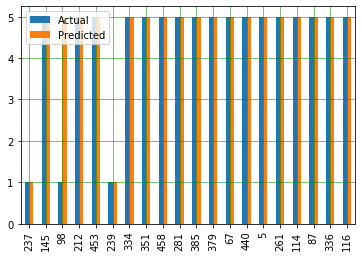

In [75]:
df1 = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1.sample(20).plot(kind='bar')
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

### Confusion Matrix

In [76]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [77]:
print(confusion_matrix(y_test, y_pred))

[[ 29   6]
 [  0 132]]


### Classification Report

In [78]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       1.00      0.83      0.91        35
           5       0.96      1.00      0.98       132

    accuracy                           0.96       167
   macro avg       0.98      0.91      0.94       167
weighted avg       0.97      0.96      0.96       167



### Accuracy Score

In [79]:
print(accuracy_score(y_test, y_pred))

0.9640718562874252
